# Library importation

In [1]:
import pandas as pd
from scipy.stats import norm 
import joblib
from sklearn.metrics import roc_auc_score
import os
import random
import xgboost
import numpy as np
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import logging
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Data Importation

In [2]:

InputSPI=pd.DataFrame()
for item in range(4):
    InputSPI=pd.concat([InputSPI,pd.read_csv('../data/SPI_training_'+str(item)+'.csv.zip')])
    
#InputSPI=cleaning_SPI(InputSPI)

InputAOI=pd.read_csv('../data/AOI_training.csv.zip')
InputSPI['PinNumber']=InputSPI['PinNumber']
InputAOI['PinNumber']=InputAOI['PinNumber'].astype('Int64').astype(str)






/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Training set creation

dict_var_info=joblib.load("dict_var_bin_info")
for var in Features_to_bin[:]:
    mean_=dict_var_info[var+'_mean']
    std_=dict_var_info[var+'_std']
    InputSPI[var]=norm.cdf(InputSPI[var], loc=mean_, scale=std_)

In [3]:
Features_to_bin=['Volume(%)',  'Area(%)', 'OffsetX(%)','OffsetY(%)']



InputAOI['AOILabel2']=InputAOI['AOILabel']
InputAOI['ComponentID2']=InputAOI['ComponentID']
InputAOI['FigureID2']=InputAOI['FigureID']


InputAOI['Count_Pin']=InputAOI.groupby(["PanelID","FigureID2","ComponentID2"])["PinNumber"].transform('count')
InputAOI['Count_Pin_Figure']=InputAOI.groupby(["PanelID","FigureID2"])["PinNumber"].transform('count')
InputAOI=InputAOI.merge(InputSPI,on=['PanelID','FigureID',"ComponentID","PinNumber"],how="inner")


InputAOI.columns

num_features=['Volume(%)','Area(%)', 'OffsetX(%)','OffsetY(%)']

InputAOI['FigureID_ComponentID']=(InputAOI['FigureID'].astype(str)+'_'+InputAOI['ComponentID'].astype(str)).astype("category").cat.codes
InputAOI['FigureID_ComponentID_PinNumber']=(InputAOI['FigureID'].astype(str)+'_'+InputAOI['ComponentID'].astype(str)+'_'+InputAOI['PinNumber'].astype(str)).astype("category").cat.codes
InputAOI['FigureID_ComponentID_PinNumber_AOILabel']=(InputAOI['FigureID'].astype(str)+'_'+InputAOI['ComponentID'].astype(str)+'_'+InputAOI['PinNumber'].astype(str)+InputAOI['AOILabel'].astype(str)).astype("category").cat.codes
InputAOI['FigureID_ComponentID_AOILabel']=(InputAOI['FigureID'].astype(str)+'_'+InputAOI['ComponentID'].astype(str)+"_"+InputAOI['AOILabel'].astype(str)).astype("category").cat.codes

list_var_to_encode=["FigureID","ComponentID","AOILabel","FigureID_ComponentID","FigureID_ComponentID_PinNumber",
                    "FigureID_ComponentID_PinNumber_AOILabel","FigureID_ComponentID_AOILabel",'PinNumber']



for var in list_var_to_encode:
    InputAOI[var]=InputAOI[var].astype('category').cat.codes
    
InputAOI['AOILabel2'].unique()

array(['Translated', 'Soldered', 'UnSoldered', 'LeanSoldering',
       'Misaligned', 'Coplanarity', 'Jumper', 'Broken'], dtype=object)

In [4]:
InputAOI['Target']=InputAOI['OperatorLabel'].astype('category').cat.codes


In [5]:
list_var_to_encode=["AOILabel","ComponentID","FigureID_ComponentID"]

Num_features_to_cat=['Volume(%)','Area(%)', 'OffsetX(%)','OffsetY(%)']
Num_features=['Shape(um)',
   'PosX(mm)', 'PosY(mm)','SizeX', 'SizeY']

# Training set Creation + Encoding with Catboost

In [6]:
Train_df=InputAOI.reset_index(drop=True)
X_train=Train_df
y_train=Train_df['Target']


encoder=ce.CatBoostEncoder()

AE_train=encoder.fit_transform(X_train[list_var_to_encode].copy(),y_train)
AE_train.columns=[x+"_encoded" for x in AE_train.columns.tolist()]
X_train_final=pd.concat([X_train,AE_train],axis=1)
joblib.dump(encoder,"Cat_boost_step2_inner")

col_features=[x+"_encoded" for x in list_var_to_encode]+Num_features+Num_features_to_cat+["Count_Pin","Count_Pin_Figure"]


X_train_final=X_train_final[col_features].to_numpy()


ratio=np.sum(y_train==0)/np.sum(y_train==1)


# Optuna hyperparametrisation

In [7]:

def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')

    param = {
        'objective': trial.suggest_categorical('objective',['binary:logistic']), 
        'tree_method': trial.suggest_categorical('tree_method',['exact']),  # 'gpu_hist','hist'
        'lambda': trial.suggest_loguniform('lambda',1e-3,10.0),
        'alpha': trial.suggest_loguniform('alpha',1e-3,10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3,1.0),
        #'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001,0.1),
        'n_estimators': trial.suggest_categorical('n_estimators', [30,40,50,70,100,150,200]),
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13,15,17,20]),
        #'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1,300),
        'nthread' : -1,
        #'feval': trial.suggest_categorical('feval',[f1_eval]),
        #'scale_pos_weight' : trial.suggest_categorical('scale_pos_weight', [ratio])
        

    }
    
    
    model = xgboost.XGBClassifier(**param,feval=f1_eval)
    
    return cross_val_score(model, X_train_final, y_train, cv=5,scoring=make_scorer(f1_score, pos_label=0)).mean()

In [8]:


def f1_eval(y_pred, y_true):
    #y_true = dtrain.get_label()
    err = f1_score(y_true,y_pred,pos_label=0)
    return 'f1_err', err

In [12]:
y_train=Train_df['Target']

study = optuna.create_study(direction='maximize')

optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

study.optimize(lambda trial : objective(trial,X_train_final,y_train),n_trials= 100)



In [13]:
Best_trial = study.best_trial.params
model = xgboost.XGBClassifier(**Best_trial)
model.fit(X_train_final,y_train)
print(confusion_matrix(y_train, model.predict(X_train_final),labels=[0,1]))
cross_val_score(model, X_train_final, y_train, cv=5,scoring=make_scorer(f1_score, pos_label=0)).mean()

[[  670   235]
 [   20 21564]]


0.7289535634000828

In [14]:
model = xgboost.XGBClassifier(**Best_trial)
model.fit(X_train_final,y_train)
joblib.dump(model,"xgboost_step2_inner")


['xgboost_step2_inner']

# Cross validation per panel score

In [51]:
list_panel_id=InputAOI.PanelID.unique().tolist()

def cross_validation_panel_id_creation(list_panel_id,n_fold=5):
    Fold_list=[]
    random.shuffle(list_panel_id)
    list_panel_id=joblib.load("list_panel_id")
    len_fold=(len(list_panel_id))//n_fold
    for fold in range(n_fold):
        Fold_list.append(list_panel_id[fold*len_fold:(fold+1)*len_fold])
    return(Fold_list)
Fold_list=cross_validation_panel_id_creation(list_panel_id)
#Final_df=Final_df.loc[Final_df['ComponentID2']!="BC1"]
f1_score_list=[]
list_confusion_matrix=[]
for Test_fold_indice in range(5):
    print(Test_fold_indice)
    Train_indice=[]
    count_indice_fit_pin_training=0
    for indices in range(len(Fold_list)):
        if indices!=Test_fold_indice:
            Train_indice=Train_indice+Fold_list[indices]
        else:
            Test_indices=Fold_list[indices]
            #Train_indice=Train_indice+Fold_list[indices]

    Train_df=InputAOI.loc[InputAOI["PanelID"].isin(Train_indice)].reset_index(drop=True)
    Test_df=InputAOI.loc[InputAOI["PanelID"].isin(Test_indices)].reset_index(drop=True)
    X_train=Train_df
    X_val=Test_df
    y_train=Train_df['Target']
    y_val=Test_df['Target']
    y_train=Train_df['Target']
    y_train=Train_df['Target']
    y_val=Test_df['Target']

    encoder=ce.CatBoostEncoder()

    AE_train=encoder.fit_transform(X_train[list_var_to_encode].copy(),y_train)
    AE_train.columns=[x+"_encoded" for x in AE_train.columns.tolist()]
    X_train_final=pd.concat([X_train,AE_train],axis=1)
    joblib.dump(encoder,"Cat_boost_step2_inner")

    AE_val=encoder.transform(X_val[list_var_to_encode].copy())
    AE_val.columns=[x+"_encoded" for x in AE_val.columns.tolist()]
    X_val_final=pd.concat([X_val,AE_val],axis=1)

    
    #col_features=["AOILabel_encoded"]+Features_to_bin
    col_features=[x+"_encoded" for x in list_var_to_encode]+Num_features+Num_features_to_cat+["Count_Pin","Count_Pin_Figure"]
    
    
    X_train_final=X_train_final[col_features].to_numpy()
    X_val_final=X_val_final[col_features].to_numpy()
    ratio=np.sum(y_train==0)/np.sum(y_train==1)
    
    

    xgb_cl = model
    xgb_cl.fit(X_train_final, y_train)
    joblib.dump(xgb_cl,"xgboost_step2_inner")

    res_train=xgb_cl.predict(X_train_final)
    res_test=xgb_cl.predict(X_val_final)

    X_train['Pred']=res_train
    X_val['Pred']=res_test
   
    
    y_train=X_train.groupby(["PanelID","FigureID","ComponentID"])['Target'].min()
    y_val=X_val.groupby(["PanelID","FigureID","ComponentID"])['Target'].min()


    res_train=X_train.groupby(["PanelID","FigureID","ComponentID"])['Pred'].min()
    res_test=X_val.groupby(["PanelID","FigureID","ComponentID"])['Pred'].min()




    print(confusion_matrix(y_train, res_train,labels=[0,1]))
    print(confusion_matrix(y_val,res_test,labels=[0,1]))

    print(f1_score(y_train, res_train,pos_label=0))
    print(f1_score(y_val, res_test,pos_label=0))
    f1_score_list.append(f1_score(y_val, res_test,pos_label=0))

0
[[  258    80]
 [    0 19843]]
[[  39    4]
 [   0 4145]]
0.8657718120805369
0.951219512195122
1
[[  258    80]
 [    0 19843]]
[[  28   13]
 [   0 3887]]
0.8657718120805369
0.8115942028985507
2
[[  258    80]
 [    0 19843]]
[[ 105   13]
 [   0 3996]]
0.8657718120805369
0.9417040358744395
3
[[  258    80]
 [    0 19843]]
[[  50   39]
 [   0 3810]]
0.8657718120805369
0.7194244604316548
4
[[  258    80]
 [    0 19843]]
[[  36   11]
 [   0 4005]]
0.8657718120805369
0.8674698795180723


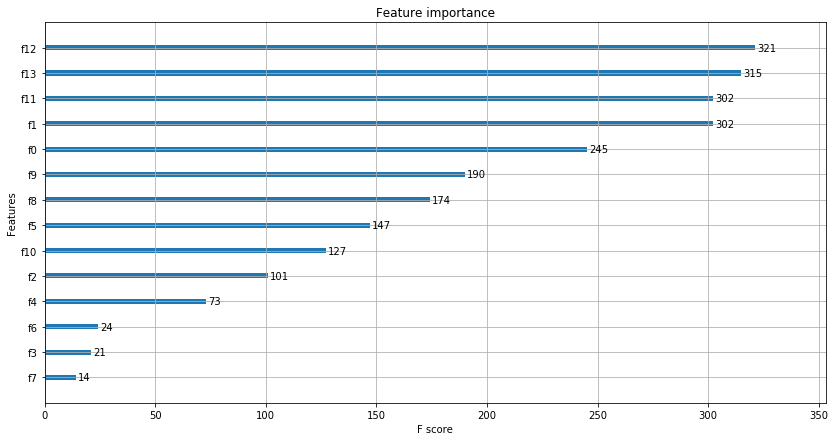

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(booster=model)